In [1]:
# ----------------------------------------
# 📦 Imports & Setup
# ----------------------------------------

import sys
sys.path.insert(0, "..")

import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.spatial.transform import Rotation as R


import torch
from torch.nn import functional as F

from app.vjepa_droid.transforms import make_transforms
from utils.mpc_utils import compute_new_pose

# Check CUDA
print(f"Cuda available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Cuda available: True


In [2]:
# ----------------------------------------
# 📂 Load Demo Data
# ----------------------------------------

pickle_path = "/data/maddie/vjepa2/data/demos/coffee_table/world_model_eval/scene_5/1754377134.pickle"
with open(pickle_path, "rb") as f:
    data = pickle.load(f)

print("Top-level keys:", list(data.keys()))
print("['base'] keys:", list(data["base"].keys()))
print("['video'] keys:", list(data["video"].keys()))


print("['video']['camera_names'] keys: ", data["video"]["camera_names"])
print("['video']['fps']: ", data["video"]["fps"])

ee = np.asarray(data["video"].get("ee_states", []))
print("['video']['ee_states'] shape:", ee.shape)

# List cameras
print("camera_names:", data["video"]["camera_names"])

# Pick one camera and sanity-check it exists
cam = "rear_camera"
assert cam in data["video"]["camera_names"], f"{cam} not in camera_names"

# Inspect frames for that camera
frames = data["video"]["frames"][cam]  # dict[str] -> list of frames
print(f"{cam}: {len(frames)} frames total")

# Peek at the first frame's raw shape/dtype
raw = np.asarray(frames[0])
print("raw shape:", raw.shape, "dtype:", raw.dtype)   # often (1, H, W, 3)


Top-level keys: ['base', 'video']
['base'] keys: ['state_dicts', 'actions', 'num_envs', 'sim_freq']
['video'] keys: ['ee_states', 'frames', 'fps', 'camera_names']
['video']['camera_names'] keys:  ['rearleft_camera', 'rearright_camera', 'rear_camera', 'topdown_camera']
['video']['fps']:  4
['video']['ee_states'] shape: (60, 1, 8)
camera_names: ['rearleft_camera', 'rearright_camera', 'rear_camera', 'topdown_camera']
rear_camera: 60 frames total
raw shape: (1, 512, 512, 3) dtype: uint8


In [3]:
# ----------------------------------------
# 🖼️ Image Processing
# ----------------------------------------

def resize_image(img_array, size=(256, 256)):
    arr = np.asarray(img_array)
    if arr.ndim == 4 and arr.shape[0] == 1:   # handle (1,H,W,3)
        arr = arr[0]
    assert arr.ndim == 3 and arr.shape[2] == 3, f"Unexpected shape {arr.shape}"
    img_pil = Image.fromarray(arr.astype(np.uint8))
    return np.array(img_pil.resize(size, resample=Image.Resampling.BILINEAR))

# Example usage
raw = frames[0] # shape (1,512,512,3)
print("Frame [0] Original Shape:", raw.shape)  # Original shape
resized = resize_image(raw, (256,256))
print("Frame [0] Resized Shape: ", resized.shape)  # Resized shape

# define time step
t_curr = 10

# define and resize ground truth frames at time t_curr and t_curr+1
img_t  = resize_image(frames[t_curr],   (256,256))
img_t1 = resize_image(frames[t_curr+1], (256,256))

# Stack two consecutive frames along a new axis (time dimension)
# img_t  = current frame   (H, W, 3)  in uint8
# img_t1 = next frame      (H, W, 3)  in uint8
np_clip = np.stack([img_t, img_t1], axis=0)      # shape: (2, H, W, 3)

# Convert to torch tensor, make float32, and reorder dimensions:
# Current: (time, height, width, channels) -> want (channels, time, height, width)
clip = torch.tensor(np_clip, dtype=torch.float32) # (2, H, W, 3)
clip = clip.permute(3, 0, 1, 2) # (C=3, T=2, H, W)

# Add a batch dimension at the front:
clip = clip.unsqueeze(0) # (B=1, C=3, T=2, H, W)

# Normalize pixel values from [0, 255] → [0, 1]
clip = clip / 255.0

# Move tensor to GPU (or CPU if no GPU) for model input
clip = clip.to(device, non_blocking=True)

print(clip.shape)  # should print: (1, 3, 2, H, W)

Frame [0] Original Shape: (1, 512, 512, 3)
Frame [0] Resized Shape:  (256, 256, 3)
torch.Size([1, 3, 2, 256, 256])


In [4]:
# ----------------------------------------
# 🤖 End-Effector State Processing
# ----------------------------------------

# Load simulation/video frequency
video_fps   = data["video"]["fps"]
sim_freq    = data["base"]["sim_freq"]

# Extract raw end-effector states from the video data
raw_ee_states = np.asarray(data["video"]["ee_states"])  # Shape should be (T, 8)

# Sanity check and normalize shape to (T, 8)
if raw_ee_states.ndim == 2 and raw_ee_states.shape[1] == 8:
    ee_states = raw_ee_states
elif raw_ee_states.ndim == 3 and raw_ee_states.shape[2] == 8 and raw_ee_states.shape[1] > 0:
    ee_states = raw_ee_states[:, 0, :]  # Select first env if batched: shape (T, 8)
else:
    raise RuntimeError(f"Unexpected ee_states shape: {raw_ee_states.shape}. "
                       "Expected (T, 8) or (T, 1, 8).")

# Split into components
ee_pos = ee_states[:, :3]       # Cartesian position (x, y, z)
ee_quat = ee_states[:, 3:7]     # Orientation as quaternion (x, y, z, w)
ee_grip = ee_states[:, 7:]      # Gripper open/close scalar

# Convert quaternion to Euler angles (roll, pitch, yaw) in radians
ee_euler = R.from_quat(ee_quat).as_euler("xyz", degrees=False)

# Combine into 7D base-relative state vector: [x, y, z, roll, pitch, yaw, gripper]
ee_7d = np.concatenate([ee_pos, ee_euler, ee_grip], axis=1)  # Shape: (T, 7)

# Convert to torch tensor on correct device
ee_7d_tensor = torch.tensor(ee_7d, dtype=torch.float32, device=device)

# Extract the current state as a [1, 1, 7] tensor for model input
state = ee_7d_tensor[t_curr].unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, 7]

In [5]:
# ----------------------------------------
# 🤖 Action Processing
# ----------------------------------------
a_curr = ee_7d_tensor[t_curr + 1] - ee_7d_tensor[t_curr]
action = a_curr.unsqueeze(0).unsqueeze(0)  # shape: [1,1,7]
print("Action shape:", action.shape) 

Action shape: torch.Size([1, 1, 7])


In [6]:
# ----------------------------------------
# ⚙️ Load V-JEPA 2 Model
# ----------------------------------------

encoder, predictor = torch.hub.load("facebookresearch/vjepa2", "vjepa2_ac_vit_giant")
encoder = encoder.to(device)
predictor = predictor.to(device)

crop_size = 256
patch_size = encoder.patch_size
tokens_per_frame = (crop_size // patch_size) ** 2

print(f"Patch size: {patch_size}, Tokens per frame: {tokens_per_frame}")

Using cache found in /home/maddie/.cache/torch/hub/facebookresearch_vjepa2_main
/home/maddie/.conda/envs/vjepa2/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Patch size: 16, Tokens per frame: 256


In [7]:
# ----------------------------------------
# 🔄 Encoding & Prediction
# ----------------------------------------

def forward_target(c, normalize_reps=True):
    B, C, T, H, W = c.size()
    c = c.permute(0, 2, 1, 3, 4).flatten(0, 1).unsqueeze(2).repeat(1, 1, 2, 1, 1)
    h = encoder(c)
    h = h.view(B, T, -1, h.size(-1)).flatten(1, 2)
    return F.layer_norm(h, (h.size(-1),)) if normalize_reps else h

def step_predictor(z_hat, a_hat, s_hat, normalize_reps=False):
    z_hat = predictor(z_hat, a_hat, s_hat)[:, -tokens_per_frame:]
    if normalize_reps:
        z_hat = F.layer_norm(z_hat, (z_hat.size(-1),))
    s_hat = compute_new_pose(s_hat[:, -1:], a_hat[:, -1:])
    return z_hat, s_hat

def loss_fn(z, h):
    z = z[:, -tokens_per_frame:]
    h = h[:, -tokens_per_frame:]
    return torch.mean(torch.abs(z - h), dim=[1, 2])

# Encode and predict
start_time = time.time()
h = forward_target(clip)
z_next_pred, s_hat = step_predictor(h[:, :tokens_per_frame], action, state)
end_time = time.time()

# ----------------------------------------
# 📉 Evaluation
# ----------------------------------------

loss = loss_fn(z_next_pred, h[:, tokens_per_frame:])
cos_sim = F.cosine_similarity(z_next_pred, h[:, tokens_per_frame:], dim=-1).mean().item()
mse_loss = torch.nn.functional.mse_loss(s_hat, state)
print(f"MSE in state prediction: {mse_loss.item():.4f}")
print(f"Prediction L1 Loss: {loss.item():.4f}")
print(f"Cosine Similarity: {cos_sim:.4f}")
print(f"Prediction time: {end_time - start_time:.4f} seconds")


MSE in state prediction: 0.0011
Prediction L1 Loss: 0.4743
Cosine Similarity: 0.7757
Prediction time: 0.3304 seconds


/home/maddie/.conda/envs/vjepa2/lib/python3.12/contextlib.py:105: FutureWarning: `torch.backends.cuda.sdp_kernel()` is deprecated. In the future, this context manager will be removed. Please see `torch.nn.attention.sdpa_kernel()` for the new context manager, with updated signature.
  self.gen = func(*args, **kwds)


In [8]:
import torch.nn as nn
import torch
import numpy as np
import math

class TokenGridDecoder(nn.Module):
    def __init__(self, embed_dim, tokens_side, out_res=256, base_ch=2048):
        super().__init__()
        self.proj = nn.Conv2d(embed_dim, base_ch, kernel_size=1)

        layers, ch = [], base_ch
        steps = int(np.log2(out_res // tokens_side))  # e.g., 16->32->64->128->256
        for _ in range(steps):
            layers += [
                nn.ConvTranspose2d(ch, ch // 2, 4, 2, 1),
                nn.GroupNorm(8, ch // 2),
                nn.ReLU(inplace=True)
            ]
            ch //= 2
        layers += [nn.Conv2d(ch, 3, 3, 1, 1), nn.Sigmoid()]
        self.up = nn.Sequential(*layers)

    def forward(self, tokens):               # tokens: [B, N, D]
        B, N, D = tokens.shape
        S = int(math.sqrt(N))
        z = tokens.transpose(1, 2).reshape(B, D, S, S)  # [B, D, S, S]
        z = self.proj(z)
        return self.up(z)                     # [B, 3, 256, 256]


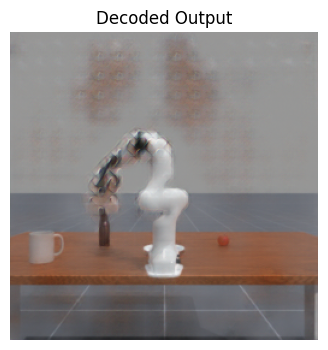

In [9]:
decoder = TokenGridDecoder(embed_dim=1408, tokens_side=16, out_res=256).cuda()
decoder.load_state_dict(torch.load("/data/maddie/vjepa2/decoder/checkpoints/run_2025-08-07_10-58-32/epoch_20.pth"))
decoder.eval()

# z_next_pred: [B, N, D]
recons = decoder(z_next_pred)    # [B, 3, 256, 256]

def show_tensor_image(tensor_img, title="Decoded Image"):
    """
    tensor_img: torch.Tensor of shape [B, 3, H, W] with values in [0, 1]
    """
    img = tensor_img[0].detach().cpu().clamp(0, 1)   # Take first image, [3, H, W]
    img = img.permute(1, 2, 0).numpy()               # [H, W, 3]

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)
    plt.show()

# Example usage:
show_tensor_image(recons, title="Decoded Output")



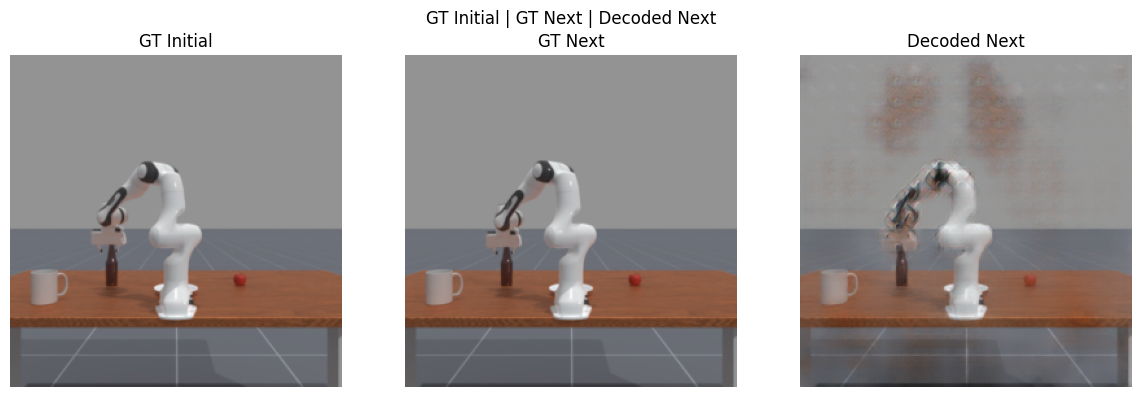

In [10]:

def compare_three(gt_initial_img, gt_next_img, decoded_img, title="GT Initial | GT Next | Decoded Next"):
    """
    gt_initial_img: [1,3,H,W] or [3,H,W] tensor in [0,1]
    gt_next_img: same shape as above
    decoded_img: same shape as above
    """
    # Ensure shape [3,H,W] and on CPU
    def prep(img):
        if img.ndim == 4:
            img = img[0]
        return img.detach().cpu().clamp(0,1)

    gt_init = prep(gt_initial_img)
    gt_next = prep(gt_next_img)
    decoded = prep(decoded_img)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for ax, im, label in zip(axes, [gt_init, gt_next, decoded],
                             ["GT Initial", "GT Next", "Decoded Next"]):
        ax.imshow(im.permute(1, 2, 0).numpy())
        ax.set_title(label)
        ax.axis("off")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Example usage:
gt_initial_tensor = torch.tensor(img_t, dtype=torch.float32).permute(2,0,1).unsqueeze(0) / 255.0
gt_next_tensor    = torch.tensor(img_t1, dtype=torch.float32).permute(2,0,1).unsqueeze(0) / 255.0

compare_three(gt_initial_tensor, gt_next_tensor, recons)



In [ ]:
# Produces a video of the ground truth vs decoded images in sliding window fashion.
import os
import torch
import imageio
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import shutil

# Make temp dir for saving comparison images
frame_dir = "video_frames"
os.makedirs(frame_dir, exist_ok=True)

# Get pickle file ID (e.g., '1754377467') for video naming
pickle_id = os.path.splitext(os.path.basename(pickle_path))[0]

# Loop through each timestep
num_frames = len(frames) - 1
frame_paths = []

for t in range(num_frames):
    # -- Images t and t+1 --
    img_t  = resize_image(frames[t],   (256, 256))
    img_t1 = resize_image(frames[t+1], (256, 256))

    np_clip = np.stack([img_t, img_t1], axis=0)  # (2, H, W, 3)
    clip = torch.tensor(np_clip, dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0) / 255.0
    clip = clip.to(device)

    # -- State & Action --
    s_t = ee_7d_tensor[t].unsqueeze(0).unsqueeze(0)  # [1, 1, 7]
    a_t = (ee_7d_tensor[t+1] - ee_7d_tensor[t]).unsqueeze(0).unsqueeze(0)  # [1, 1, 7]

    # -- Encode & Predict --
    h = forward_target(clip)
    z_next_pred, _ = step_predictor(h[:, :tokens_per_frame], a_t, s_t)
    decoded = decoder(z_next_pred)  # [1, 3, 256, 256]

    # -- Ground Truth image --
    gt_img = torch.tensor(img_t1, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device) / 255.0

    # -- Combine GT and Decoded into a grid image --
    combined = make_grid([gt_img[0], decoded[0]], nrow=2).permute(1, 2, 0).cpu().numpy()
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.imshow(combined)
    ax.set_title(f"Step {t}: GT vs Decoded")
    ax.axis("off")

    frame_path = os.path.join(frame_dir, f"frame_{t:03d}.png")
    plt.savefig(frame_path, bbox_inches='tight')
    plt.close(fig)

    frame_paths.append(frame_path)

# -- Save as video --
video_dir = "videos"
os.makedirs(video_dir, exist_ok=True)
video_path = os.path.join(video_dir, f"decoded_vs_gt_{pickle_id}.mp4")

with imageio.get_writer(video_path, fps=5) as writer:
    for frame in frame_paths:
        image = imageio.imread(frame)
        writer.append_data(image)
#
print(f"✅ Video saved to: {video_path}")

# -- Optional: clean up temp frames
shutil.rmtree(frame_dir)


In [25]:
# choose where to start intializing your rollout 
start_frame =0

# define total number of frames 
T = len(frames)
print(f"Total frames: {T}")

# build list of ground-truth frames and rezize them
gt_frames = []
for t in range(T):
    img = resize_image(frames[t], (256, 256))  # resize each frame to 256x256
    gt_frames.append(img)

# build list of actions 
actions = []
for t in range(T-1):
    delta = ee_7d_tensor[t+1] - ee_7d_tensor[t]  # compute delta between consecutive states
    a = delta.unsqueeze(0).unsqueeze(0)  # add batch and time dimensions to match downstream
    actions.append(a)  # append to actions list

# gt_frames = [resize_image(frames[t], (256,256)) for t in range(T)]
# actions = [(ee_7d_tensor[t+1]-ee_7d_tensor[t]).unsqueeze(0).unsqueeze(0) for t in range(T-1)]

# --------------------------------------------------------------------
# initialize the first two frames for the open-loop rollout
# --------------------------------------------------------------------
img_t = gt_frames[start_frame]  # get the initial frame
img_t1 = gt_frames[start_frame + 1]  # get the next frame

# build a two frame clip
np_clip = np.stack([img_t, img_t1], axis=0)

# convert to torch float
clip = torch.tensor(np_clip, dtype=torch.float32)

  # permute to be [channels, time, height, width]
clip = clip.permute(3,0,1,2)

# add batch dimension [batch, channels, time, height, width]
clip = clip.unsqueeze(0) 

# normalize [0,1]
clip = clip / 255.0

# move to GPU
clip = clip.to(device)

# encode the two frames
h = forward_target(clip)

# Extract the last frame's tokens
z = h[:, -tokens_per_frame:] 

# set the intial robot state
s0 = ee_7d_tensor[start_frame]

# add batch and time dimensions to match downstream
s = ee_7d_tensor[start_frame].unsqueeze(0).unsqueeze(0) 

# --------------------------------------------------------------------
# video writer
# --------------------------------------------------------------------
os.makedirs("videos", exist_ok=True)
out_path = os.path.join("videos", "openloop_gt_vs_pred_no_list.mp4")
fps = int(data["video"]["fps"])
writer = imageio.get_writer(out_path, fps=fps)

# --------------------------------------------------------------------
# open-loop rollout (predict t -> t+1)
# --------------------------------------------------------------------
for t in range(T-1-start_frame):
    a = actions[t + start_frame]  # get the action for this step
    with torch.no_grad():  # ensure no grads stored
        # optional debug
        print(f"\nstep {t+1}/{T-1-start_frame}")
        print(" action:", a.shape)
        print(" state:", s.shape)
        print(" z:", z.shape)

        # predict the next tokens / state
        z, s = step_predictor(z, a, s, normalize_reps=True)

        # decode the predicted tokens to an image
        pred = decoder(z).clamp(0, 1).cpu()  # move to CPU immediately

        # prepare the ground truth image for this step
        # correct GT indexing: always start from start_frame
        gt_idx = start_frame + 1 + t
        gt_tensor = torch.tensor(gt_frames[gt_idx], dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
        
        # side-by-side grid for video
        frame = make_grid([gt_tensor[0], pred[0]], nrow=2).permute(1, 2, 0).numpy()
        writer.append_data((frame * 255).astype(np.uint8))

    # free unused memory (optional; can be commented out if it slows you down)
    torch.cuda.empty_cache()

writer.close()
print(f"✅ Saved: {out_path}")


Total frames: 60

step 1/59
 action: torch.Size([1, 1, 7])
 state: torch.Size([1, 1, 7])
 z: torch.Size([1, 256, 1408])
[WARNING ][2025-08-11 21:01:01][imageio_ffmpeg      ][write_frames             ] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (518, 260) to (528, 272) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

step 2/59
 action: torch.Size([1, 1, 7])
 state: torch.Size([1, 1, 7])
 z: torch.Size([1, 256, 1408])

step 3/59
 action: torch.Size([1, 1, 7])
 state: torch.Size([1, 1, 7])
 z: torch.Size([1, 256, 1408])

step 4/59
 action: torch.Size([1, 1, 7])
 state: torch.Size([1, 1, 7])
 z: torch.Size([1, 256, 1408])

step 5/59
 action: torch.Size([1, 1, 7])
 state: torch.Size([1, 1, 7])
 z: torch.Size([1, 256, 1408])

step 6/59
 action: torch.Size([1, 1, 7])
 state: torch.Size([1, 1,

In [ ]:
import os, torch, imageio, numpy as np
from torchvision.utils import make_grid
from torch.nn import functional as F

# def encode_single_image(image):
#     # convert to tensor
#     x = torch.tensor(image, dtype=torch.float32)

#     # normalize [0,1]
#     x = x / 255.0

#     # permute to be [channels, height, width]
#     x = x.permute(2,0,1)

#     # add batch dimension [batch, channels, height, width]
#     x = x.unsqueeze(0)

#     # Note: the VJEPA 2 encoder takes in two images at a time
#     #       therefore, we need to 'fake' a second image to feed into the encoder
#     #       insert a time dimension at position 2 [Batch, channels, time, height, width]
#     x = x.unsqueeze(2)
    
#     # repeats data along the time dimension (an does nothing elsewhere; e.g. 1)
#     # Before: [1, 3, 1, 256, 256]
#     # After: [1, 3, 2, 256, 256]
#     clip = x.repeat(1, 1, 2, 1, 1)

#     # move to GPU (if available)
#     clip = clip.to(device) 

#     # Run the encoder
#     h = encoder(clip)

#     # Extract the last frames tokens
#     z = h[:, -tokens_per_frame:, :]

#     # Normalize the tokens
#     z = F.layer_norm(z, (z.size(-1),))

#     return z

# --------------------------------------------------------------------
# prepare ground-truth(gt) frames & actions
# --------------------------------------------------------------------



Total frames: 60

step 1/37
 action: torch.Size([1, 1, 7])
 state: torch.Size([1, 1, 7])
 z: torch.Size([1, 256, 1408])
[WARNING ][2025-08-11 20:55:38][imageio_ffmpeg      ][write_frames             ] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (518, 260) to (528, 272) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).

step 2/37
 action: torch.Size([1, 1, 7])
 state: torch.Size([1, 1, 7])
 z: torch.Size([1, 256, 1408])

step 3/37
 action: torch.Size([1, 1, 7])
 state: torch.Size([1, 1, 7])
 z: torch.Size([1, 256, 1408])

step 4/37
 action: torch.Size([1, 1, 7])
 state: torch.Size([1, 1, 7])
 z: torch.Size([1, 256, 1408])

step 5/37
 action: torch.Size([1, 1, 7])
 state: torch.Size([1, 1, 7])
 z: torch.Size([1, 256, 1408])

step 6/37
 action: torch.Size([1, 1, 7])
 state: torch.Size([1, 1,

In [15]:

def encode_single_image(img_uint8_256):
    x = torch.tensor(img_uint8_256, dtype=torch.float32).permute(2,0,1).unsqueeze(0) / 255.0   # [1,3,256,256]
    clip = x.unsqueeze(2).repeat(1,1,2,1,1).to(device, non_blocking=True)                      # [1,3,2,256,256]
    h = encoder(clip)                                                                          # [1,2*N,D]
    z = h[:, -tokens_per_frame:, :]                                                            # [1,N,D]
    z = F.layer_norm(z, (z.size(-1),))
    return z

# --- prepare GT + actions ---
start_frame = 0
T = len(frames)
gt = [resize_image(frames[t], (256,256)) for t in range(T)]
actions = [(ee_7d_tensor[t+1]-ee_7d_tensor[t]).unsqueeze(0).unsqueeze(0) for t in range(T-1)]

# --- init ---
img_t  = resize_image(gt[start_frame],   (256, 256))
img_t1 = resize_image(gt[start_frame+1], (256, 256))

np_clip = np.stack([img_t, img_t1], axis=0)  # (2, H, W, 3)
clip = torch.tensor(np_clip, dtype=torch.float32).permute(3, 0, 1, 2).unsqueeze(0) / 255.0
clip = clip.to(device)
#z = encode_single_image(gt[0])
z = forward_target(clip)[:, -tokens_per_frame:]  # [1, N, D]
s = ee_7d_tensor[0].unsqueeze(0).unsqueeze(0)
print(f"Initial state: {s}, z shape: {z.shape}")
print("second state: ", ee_7d_tensor[2].unsqueeze(0).unsqueeze(0))

# --- output video writer ---
os.makedirs("videos", exist_ok=True)
out_path = os.path.join("videos", "openloop_gt_vs_pred.mp4")
fps = int(data["video"]["fps"])
writer = imageio.get_writer(out_path, fps=fps)

# --- roll open-loop ---
for t in range(T-1-start_frame):
    a = actions[t+start_frame]
    with torch.no_grad():  # ensure no grads stored
        print("action: ", a)
        print("state: ", s)
        print("z shape: ", z.shape)
        z, s = step_predictor(z, a, s, normalize_reps=True)  # predict
        pred = decoder(z).clamp(0,1).cpu()                  # move to CPU immediately
        gt_tensor = torch.tensor(gt[t+1], dtype=torch.float32).permute(2,0,1).unsqueeze(0)/255.0
        frame = make_grid([gt_tensor[0], pred[0]], nrow=2).permute(1,2,0).numpy()
        writer.append_data((frame*255).astype(np.uint8))
    torch.cuda.empty_cache()  # free unused memory

writer.close()
print(f"✅ Saved: {out_path}")

Initial state: tensor([[[ 3.3601e-03, -3.8377e-03,  1.8031e-01,  3.1063e+00, -2.0445e-03,
           3.1375e+00,  4.0000e-02]]], device='cuda:0'), z shape: torch.Size([1, 256, 1408])
second state:  tensor([[[ 1.8848e-03,  8.1024e-03,  1.8030e-01,  3.1075e+00, -2.0541e-03,
           3.1374e+00,  4.0000e-02]]], device='cuda:0')
action:  tensor([[[0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0')
state:  tensor([[[ 3.3601e-03, -3.8377e-03,  1.8031e-01,  3.1063e+00, -2.0445e-03,
           3.1375e+00,  4.0000e-02]]], device='cuda:0')
z shape:  torch.Size([1, 256, 1408])
[WARNING ][2025-08-11 20:47:11][imageio_ffmpeg      ][write_frames             ] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (518, 260) to (528, 272) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
action:  tensor([[[-1.4753e

In [ ]:
# TEST JUST ENCODER / DECODER on ground truth  no predictor
# --- TF-ENC: decode encoder tokens for every GT frame, keep results on CPU ---
tf_frames = []
for t in range(T):
    z_enc_t = encode_single_image(gt_frames_256[t])     # [1, N, D] on device
    img_rec = decoder(z_enc_t).clamp(0, 1).detach().cpu()  # move to CPU here
    tf_frames.append(img_rec)                           # list of [1,3,256,256] on CPU

# --- Save GT vs TF-ENC video (everything on CPU) ---
import os, imageio, numpy as np
from torchvision.utils import make_grid

os.makedirs("videos", exist_ok=True)
tf_enc_video_path = os.path.join("videos", "tf_encoder_vs_gt.mp4")
fps = int(data['video']['fps'])

with imageio.get_writer(tf_enc_video_path, fps=fps) as w:
    for t in range(T):
        # GT to CPU tensor CHW in [0,1]
        gt_img = (torch.tensor(gt_frames_256[t], dtype=torch.float32)
                    .permute(2,0,1) / 255.0)  # [3,256,256] on CPU

        # Both tensors on CPU, same dtype
        pair = [gt_img, tf_frames[t][0]]  # CHW, CHW
        combined = make_grid(pair, nrow=2).permute(1,2,0).numpy()  # HWC float
        w.append_data((combined * 255).astype(np.uint8))

print(f"✅ Teacher-forcing (encoder only) video saved to: {tf_enc_video_path}")


In [ ]:
# ---- TF-PRED: one-step predictions with teacher forcing (no open-loop) ----
import os, imageio, numpy as np, torch
from torchvision.utils import make_grid
from torch.nn import functional as F

tf_pred_frames = []
latent_L1s, cos_sims = [], []

fps = int(data['video']['fps'])
os.makedirs("videos", exist_ok=True)
tf_pred_video_path = os.path.join("videos", "tf_pred_vs_gt.mp4")

for t in range(T - 1):
    # Encode GT_t to tokens (what predictor was trained to see)
    z_enc_t = encode_single_image(gt_frames_256[t])              # [1,N,D] on device
    # Keep tokens normalized if predictor expects it
    z_enc_t = F.layer_norm(z_enc_t, (z_enc_t.size(-1),))         # comment out if not used in training

    # Build Δstate_t and state_t  (your predictor uses Δstate actions)
    s_t = ee_7d_tensor[t].view(1,1,-1).to(z_enc_t.device)
    a_t = (ee_7d_tensor[t+1] - ee_7d_tensor[t]).view(1,1,-1).to(z_enc_t.device)
    # If you used z-scoring during training, apply it here:
    # a_t = (a_t - action_mean) / action_std
    # s_t = (s_t - state_mean)  / state_std

    # One-step predict tokens for t+1
    z_pred_next, _ = step_predictor(z_enc_t, a_t, s_t, normalize_reps=True)  # [1,N,D]

    # Decode predicted tokens -> image
    pred_img = decoder(z_pred_next).clamp(0,1).detach().cpu()                # [1,3,256,256]
    tf_pred_frames.append(pred_img)

    # Diagnostic latent metrics vs encoder(GT_{t+1})  (not fed forward; just for metrics)
    with torch.no_grad():
        h_gt_next = encode_single_image(gt_frames_256[t+1])                  # [1,N,D]
        h_gt_next = F.layer_norm(h_gt_next, (h_gt_next.size(-1),))
    latent_L1s.append(torch.mean(torch.abs(z_pred_next - h_gt_next)).item())
    cos_sims.append(F.cosine_similarity(z_pred_next, h_gt_next, dim=-1).mean().item())

# Save GT vs TF-PRED video (everything on CPU for writing)
with imageio.get_writer(tf_pred_video_path, fps=fps) as w:
    for t in range(T - 1):
        gt_img = (torch.tensor(gt_frames_256[t+1], dtype=torch.float32)
                    .permute(2,0,1) / 255.0)                                # [3,256,256] CPU
        pair = [gt_img, tf_pred_frames[t][0]]                                # CHW, CHW (CPU)
        combined = make_grid(pair, nrow=2).permute(1,2,0).numpy()            # HWC float
        w.append_data((combined * 255).astype(np.uint8))

print(f"✅ TF-PRED video saved to: {tf_pred_video_path}")
print(f"Avg latent L1: {np.mean(latent_L1s):.4f} | Avg cosine: {np.mean(cos_sims):.4f}")

